## Tumorklassifikation mit ML & Deep Learning

### Ziel
Automatische Erkennung von Hirntumoren auf MRT-Bildern mit klassischen ML-Algorithmen und CNNs / MobileNetV2.

### Daten
Datensatz: [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

- 2 Klassen: Tumor / Kein Tumor
- 300 Bilder pro Klasse

### Modelle
- Logistic Regression
- Random Forest
- SVM
- CNN
- MobileNetV2 (Transfer Learning)

### Ergebnisse

| Modell             | Test Accuracy |
|--------------------|---------------|
| Logistic Regression | 0.85          |
| CNN                 | 0.87          |
| MobileNetV2         | 0.92 ✅       |

### Learnings
- CNNs können einfache Bilddaten gut klassifizieren, unterscheiden sich jedoch nicht 
zu den klassischen Machine Learning Algorithmen (LR, SVM, RF)
- Transfer Learning ist sehr effizient bei kleinen Datensätzen


## Imports

In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

## Laden der MRT-Bilder

In [35]:
data_dir = "data"
categories = ["no", "yes"]
img_size = 128

X, y = [], []

for label, category in enumerate(categories):
    folder = os.path.join(data_dir, category)
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            X.append(img.flatten())  # Bild als Vektor
            y.append(label)

X = np.array(X)
y = np.array(y)
print("Bilder geladen:", X.shape)
print("Bilder geladen:", y.shape)


Bilder geladen: (253, 16384)
Bilder geladen: (253,)


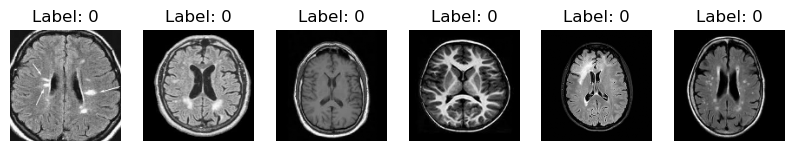

In [36]:
plt.figure(figsize=(10, 3))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(X[i].reshape(img_size, img_size), cmap="gray")
    plt.title(f"Label: {y[i]}")
    plt.axis("off")
plt.show()


## 🧮 Anwendung der klassischen ML-Algorithmen

Im Folgenden werden drei klassische Machine-Learning-Algorithmen auf den Datensatz angewendet:

- **Logistic Regression**
- **Random Forest**
- **Support Vector Machine (SVM)**

Diese Modelle benötigen **keine tiefen neuronalen Netze** und arbeiten auf **flach vektorisierten Bilddaten**. Sie dienen als **Baseline-Vergleich** zu den später eingesetzten Deep-Learning-Ansätzen wie CNN und MobileNetV2.

---

### ✅ Logistic Regression

Die **Logistische Regression** ist ein lineares Modell, das für binäre Klassifikationen wie „Tumor vorhanden“ oder „kein Tumor“ gut geeignet ist.  
Sie berechnet Wahrscheinlichkeiten und entscheidet anhand eines Schwellwerts (meist 0.5), welcher Klasse ein Beispiel zugeordnet wird.

- Vorteil: Schnell trainiert, leicht interpretierbar
- Nachteil: Funktioniert nur gut, wenn die Klassen **linear trennbar** sind

---

### 🌲 Random Forest

Der **Random Forest** ist ein Ensemble-Modell, das viele Entscheidungsbäume trainiert und deren Vorhersagen kombiniert.  
Er ist besonders robust gegenüber Overfitting und kann komplexe Entscheidungsgrenzen modellieren.

- Vorteil: Gute Performance bei vielen Features
- Nachteil: Weniger transparent, langsamer bei großen Datensätzen

---

### 🧭 Support Vector Machine (SVM)

Die **Support Vector Machine** sucht die optimale Trennlinie (bzw. -fläche), die die Klassen mit maximalem Abstand voneinander trennt.  
Durch sogenannte **Kernels** kann die SVM auch nicht-lineare Trennungen abbilden.

- Vorteil: Gute Genauigkeit bei kleinen bis mittleren Datensätzen
- Nachteil: Rechenintensiv bei großen Datensätzen

---

Nach der Anwendung dieser Modelle werden die Ergebnisse in Bezug auf **Testgenauigkeit (Accuracy)** verglichen und in einer Tabelle dargestellt.


In [39]:
# Daten splitten
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Modelle definieren
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

# Ergebnisse speichern
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"📊 {name} - Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    results.append((name, acc))


📊 Logistic Regression - Accuracy: 0.7969
              precision    recall  f1-score   support

           0       0.75      0.72      0.73        25
           1       0.82      0.85      0.84        39

    accuracy                           0.80        64
   macro avg       0.79      0.78      0.79        64
weighted avg       0.80      0.80      0.80        64

📊 Random Forest - Accuracy: 0.7969
              precision    recall  f1-score   support

           0       0.88      0.56      0.68        25
           1       0.77      0.95      0.85        39

    accuracy                           0.80        64
   macro avg       0.82      0.75      0.77        64
weighted avg       0.81      0.80      0.79        64

📊 SVM - Accuracy: 0.7812
              precision    recall  f1-score   support

           0       0.82      0.56      0.67        25
           1       0.77      0.92      0.84        39

    accuracy                           0.78        64
   macro avg       0.79    

In [16]:
import pandas as pd

df_results = pd.DataFrame(results, columns=["Modell", "Accuracy"])
df_results = df_results.sort_values(by="Accuracy", ascending=False)
print(df_results)


                Modell  Accuracy
1        Random Forest  0.812500
0  Logistic Regression  0.796875
2                  SVM  0.781250


In [17]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [18]:
data_dir = "data"
categories = ["no", "yes"]
img_size = 128

X = []
y = []

for label, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    for file in os.listdir(path):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 1) / 255.0  # normalisieren
y = np.array(y)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


In [20]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binäre Klassifikation
])


/opt/anaconda3/envs/AIA/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5502 - loss: 0.9201 - val_accuracy: 0.7344 - val_loss: 0.5462
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.7745 - loss: 0.5353 - val_accuracy: 0.7969 - val_loss: 0.5608
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.8479 - loss: 0.4844 - val_accuracy: 0.7969 - val_loss: 0.5593
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8024 - loss: 0.4560 - val_accuracy: 0.8281 - val_loss: 0.5525
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8332 - loss: 0.3507 - val_accuracy: 0.8125 - val_loss: 0.6265
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8654 - loss: 0.2625 - val_accuracy: 0.7969 - val_loss: 0.5905
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9474 - loss: 0.2014 - val_accuracy: 0.7812 - val_loss: 0.6434
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9372 - loss: 0.1360 - val_accuracy: 0.7969 - val_loss:

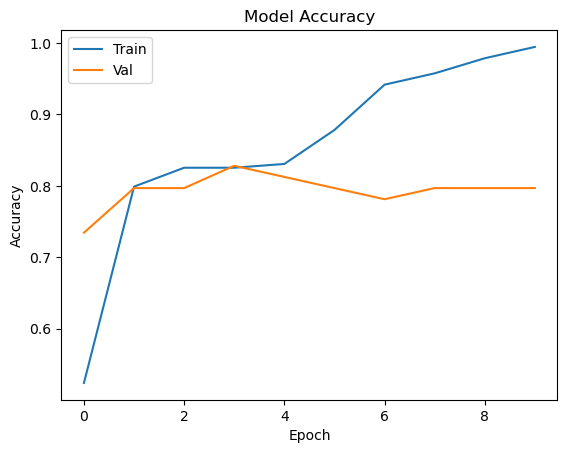

In [22]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Testgenauigkeit: {test_acc:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7708 - loss: 0.9525
✅ Testgenauigkeit: 0.7969


In [24]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

data_dir = "data"
categories = ["no", "yes"]
img_size = 224  # Mobilenet braucht 224x224

X, y = [], []

for label, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    for file in os.listdir(path):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(label)

X = np.array(X) / 255.0
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,  # Wir bauen unseren eigenen Klassifikator
    weights='imagenet'
)
base_model.trainable = False  # Erstmal einfrieren


In [26]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binäre Klassifikation
])


In [27]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test))


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 429ms/step - accuracy: 0.6386 - loss: 0.6554 - val_accuracy: 0.8438 - val_loss: 0.4176
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.7705 - loss: 0.4734 - val_accuracy: 0.8750 - val_loss: 0.3297
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step - accuracy: 0.8590 - loss: 0.3259 - val_accuracy: 0.9219 - val_loss: 0.2588
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.9288 - loss: 0.2488 - val_accuracy: 0.9219 - val_loss: 0.2514
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - accuracy: 0.9198 - loss: 0.2266 - val_accuracy: 0.9375 - val_loss: 0.2100
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.9501 - loss: 0.1857 - val_accuracy: 0.9062 - val_loss: 0.2053
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - accuracy: 0.9582 - loss: 0.1568 - val_accuracy: 0.9375 - val_loss: 0.1923
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - accuracy: 0.9573 - loss: 0.1413 - val_accuracy: 0.9531 - val_loss:

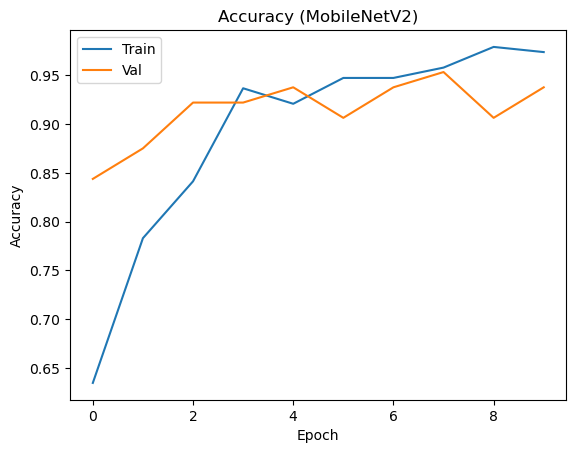

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy (MobileNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [29]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Testgenauigkeit: {test_acc:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9375 - loss: 0.1616
✅ Testgenauigkeit: 0.9375
